In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Downloads/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
cat=df["Category"].value_counts()
cat

ham     4825
spam     747
Name: Category, dtype: int64

In [4]:
#convert labels to numerical values
df['label'] = df['Category'].apply(lambda rating : 1 if rating !='spam' else 0)

In [5]:
sentences = df['Message'].tolist()
labels = df['label'].tolist()

In [6]:
# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [9]:
#the data is tokenized- a unique number is assigned to each word
#vocabulary size of 1,000 with a maximum length of 100
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [11]:
#the tokens are sorted into sequences to ensure they are in the correct order
sequences = tokenizer.texts_to_sequences(training_sentences)

In [12]:
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

ok lar <OOV> wif u <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Ok lar... Joking wif u oni...


In [14]:
#padding introduces 0's at the end of each sentence for when sentences are longer than each other
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
#flatten is used to reduce multidimensional tensors to a one-dimensional tensor
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 6)                 9606      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 25,613
Trainable params: 25,613
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
140/140 [==============================] - 1s 5ms/step - loss: 0.3222 - accuracy: 0.8640 - val_loss: 0.1759 - val_accuracy: 0.8700
Epoch 2/30
140/140 [==============================] - 0s 3ms/step - loss: 0.1623 - accuracy: 0.9334 - val_loss: 0.1391 - val_accuracy: 0.9767
Epoch 3/30
140/140 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9787 - val_loss: 0.0639 - val_accuracy: 0.9785
Epoch 4/30
140/140 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 0.9877 - val_loss: 0.0513 - val_accuracy: 0.9821
Epoch 5/30
140/140 [==============================] - 0s 3ms/step - loss: 0.0311 - accuracy: 0.9910 - val_loss: 0.0513 - val_accuracy: 0.9830
Epoch 6/30
140/140 [==============================] - 0s 3ms/step - loss: 0.0244 - accuracy: 0.9930 - val_loss: 0.0495 - val_accuracy: 0.9865
Epoch 7/30
140/140 [==============================] - 0s 3ms/step - loss: 0.0191 - accuracy: 0.9951 - val_loss: 0.0529 - val_accuracy: 0.9857
Epoch 

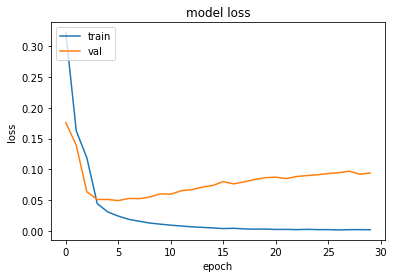

In [16]:
num_epochs = 30
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [18]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [19]:
# Use the model to predict whether a message is spam
text_messages = ['Meadhbh, can you text back once you get this?',
                'Congrats on your new iPhone! Click here to claim your prize...', 
                'How are you feeling?',
                'Did you hear the people sing?',
                'Attend this data science course today: Book your session now...']

print(text_messages) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(text_messages)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(text_messages)):
  print(text_messages[x])
  print(classes[x])
  print('\n')

['Meadhbh, can you text back once you get this?', 'Congrats on your new iPhone! Click here to claim your prize...', 'How are you feeling?', 'Did you hear the people sing?', 'Attend this data science course today: Book your session now...']
Meadhbh, can you text back once you get this?
[0.9999515]


Congrats on your new iPhone! Click here to claim your prize...
[0.01143718]


How are you feeling?
[0.9999151]


Did you hear the people sing?
[0.9994391]


Attend this data science course today: Book your session now...
[0.8075272]


